In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import Convolution2D, MaxPooling2D
from tensorflow.keras.applications.vgg16 import VGG16 
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import numpy as np
import glob 

#variables for ResNet50 model
EPOCHS = 16
LAYERS = 2

In [2]:
AUTOTUNE = tf.data.AUTOTUNE

In [3]:
DATA_DIR = "Data/COVID-19_Radiography_Dataset"
DATA_DIR = pathlib.Path(DATA_DIR)

In [4]:
img_height = 64
img_width = 64
batch_size = 16 
input_shape = (img_height, img_width, 3)

In [5]:
train_datagen = ImageDataGenerator()

In [6]:
image_count = len(list(DATA_DIR.glob("*/*.png")))

In [7]:
dataset_fraction = 0.05
test_fraction = 0.2
validate_fraction = 0.2

In [8]:
def get_train_validate_test_sizes(
    image_count, 
    dataset_fraction, 
    test_fraction, 
    validate_fraction
):
    image_count = int(dataset_fraction * image_count)
    test_size = int(image_count * test_fraction)
    training = image_count - test_size
    validate_size = int(validate_fraction * training)
    train_size =  training - validate_size
    
    return train_size, validate_size, test_size

In [9]:
train_size, validate_size, test_size = get_train_validate_test_sizes(
    image_count, 
    dataset_fraction, 
    test_fraction, 
    validate_fraction
)

train_size, validate_size, test_size

(442, 110, 138)

In [10]:
def get_all_files(directory, image_count):
    list_ds = tf.data.Dataset.list_files(str(directory/'*/*'), shuffle=False)
    list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)
    
    return list_ds

In [11]:
def get_class_names(directory):
    return list(sorted([item.name for item in directory.glob('*') if item.is_dir()]))

In [12]:
class_names = get_class_names(DATA_DIR)

In [13]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    one_hot = parts[-2] == class_names
    return tf.argmax(one_hot)


In [14]:
def decode_img(img):
    img = tf.image.decode_png(img, channels=3)
    return tf.image.resize(img, [img_height, img_width])

In [15]:
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [16]:
def configure_for_performance(ds, batch_size):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [17]:
def get_train_validate_test(
    directory,
    image_count,
    train_val_test_sizes,
    batch_size
):
    train_size, validate_size, test_size = train_val_test_sizes
    
    list_ds = get_all_files(directory, image_count)
    
    train_ds = list_ds.take(train_size)
    val_ds = list_ds.take(validate_size)
    test_ds = list_ds.take(test_size)
    
#     for dataset in [train_ds, val_ds, test_ds]:
    train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    train_ds = configure_for_performance(train_ds, batch_size)

    val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    val_ds = configure_for_performance(val_ds, batch_size)

    test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    test_ds = configure_for_performance(test_ds, batch_size)
    
    return train_ds, val_ds, test_ds

In [18]:
def plot_batch(image_batch, label_batch, class_names):
    plt.figure(figsize=(10, 100))
    batch_size = image_batch.shape[0]
    for i in range(batch_size):
        ax = plt.subplot(batch_size, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        label = label_batch[i]
        plt.title(class_names[label])
        plt.axis("off")


In [19]:
train_ds, val_ds, test_ds = get_train_validate_test(
    DATA_DIR,
    image_count,
    (train_size, validate_size, test_size),
    batch_size
)

In [20]:
image_batch, label_batch = next(iter(train_ds))
test_image_batch, test_label_batch = next(iter(test_ds))

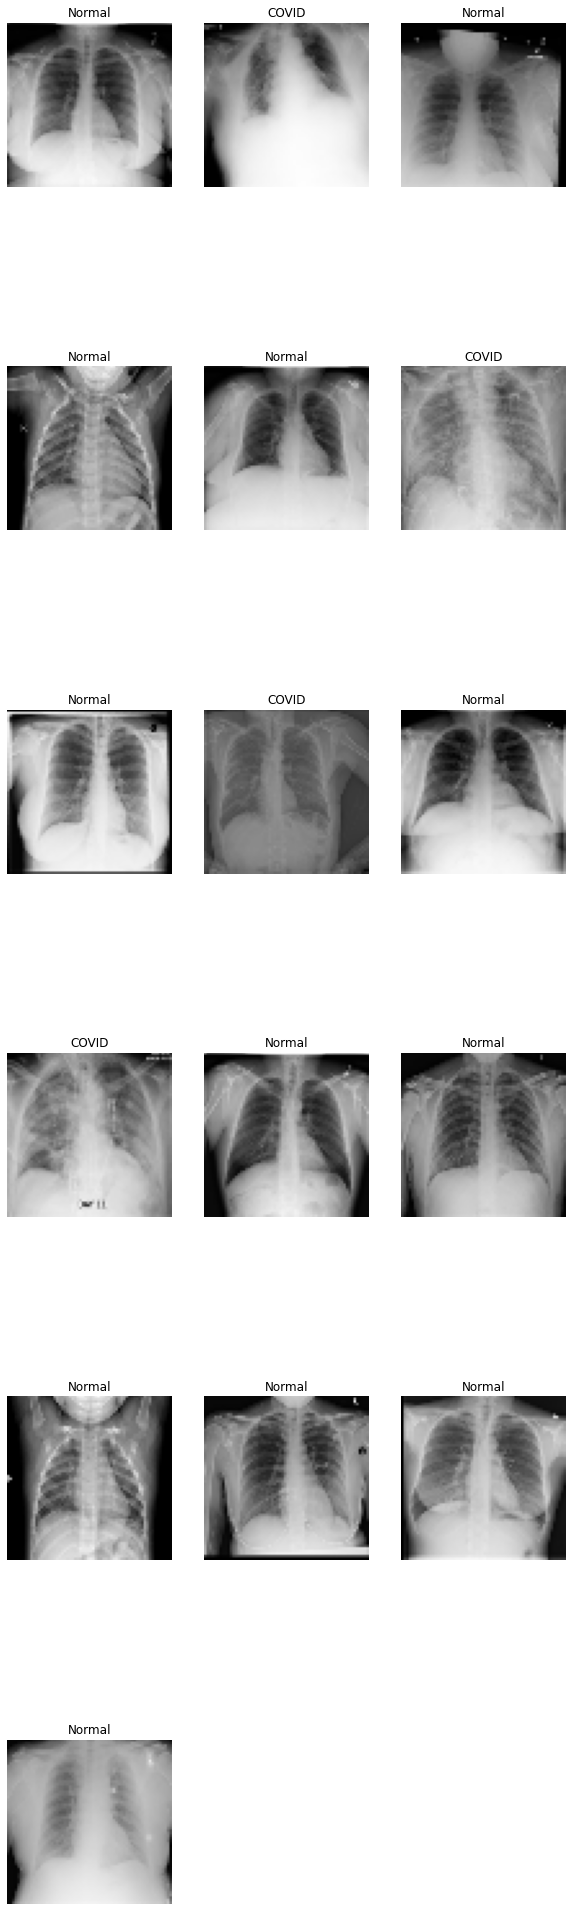

In [21]:
plot_batch(image_batch, label_batch, class_names)

In [22]:
data_augmentation = tf.keras.Sequential(
    [
        preprocessing.RandomRotation(0.1),
        preprocessing.RandomZoom(0.1),
    ]
)

classes = 2
inputs = tf.keras.Input(shape=input_shape)
x = data_augmentation(inputs)
# Rescale image values to [0, 1]
x = preprocessing.Rescaling(1.0 / 255)(x)


In [23]:
# resnet = tf.keras.applications.ResNet50(
#     weights="imagenet", input_shape=input_shape,
#     include_top=False
# )
# resnet.trainable = False
# for i in range(1, LAYERS+1):
#     resnet.layers[-i].trainable = True
# x = resnet(x, training=False)

# vgg = VGG16(
#     include_top=False,
#     weights="imagenet",
#     input_shape=input_shape
#     )
# vgg.trainable = False
# x = vgg(x, training=False)

In [24]:
from tensorflow.keras.optimizers import Adam

In [25]:
def get_own_model():
    model=tf.keras.Sequential()
#     model.add(preprocessing.Rescaling(1.0 / 255)) #uncommenting causes worse results (?!) but smaller val_loss
    model.add(tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(64, 64, 3)))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"))
    model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(16))
    model.add(tf.keras.layers.Dropout(.15, input_shape=(16,)))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    return model

In [26]:
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)

In [27]:
model = get_own_model()
#comment above line if you dont want to use that model

In [28]:
# model = Model(inputs, x)
#uncomment above line if you dont want to use get_own_model

In [29]:
model.compile( loss='binary_crossentropy',
               optimizer=Adam(learning_rate=0.0001),
               metrics=['accuracy']
             )
history = model.fit(train_ds, validation_data=val_ds,
           batch_size=batch_size, epochs=EPOCHS, verbose=1)

Epoch 1/16
28/28 [==============================] - 3s 53ms/step - loss: 9.5515 - accuracy: 0.6041 - val_loss: 3.0629 - val_accuracy: 0.6545
Epoch 2/16
28/28 [==============================] - 1s 43ms/step - loss: 4.5390 - accuracy: 0.6448 - val_loss: 1.9628 - val_accuracy: 0.7364
Epoch 3/16
28/28 [==============================] - 1s 39ms/step - loss: 2.5423 - accuracy: 0.6991 - val_loss: 2.5787 - val_accuracy: 0.6000
Epoch 4/16
28/28 [==============================] - 1s 38ms/step - loss: 2.3254 - accuracy: 0.7149 - val_loss: 2.2682 - val_accuracy: 0.7909
Epoch 5/16
28/28 [==============================] - 1s 39ms/step - loss: 1.9749 - accuracy: 0.7557 - val_loss: 3.3473 - val_accuracy: 0.5273
Epoch 6/16
28/28 [==============================] - 1s 40ms/step - loss: 1.5461 - accuracy: 0.7489 - val_loss: 0.7191 - val_accuracy: 0.8364
Epoch 7/16
28/28 [==============================] - 1s 41ms/step - loss: 0.6323 - accuracy: 0.8439 - val_loss: 0.5599 - val_accuracy: 0.8727
Epoch 8/16
28

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                100368    
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)               

In [31]:
df = pd.DataFrame(history.history)
df.index += 1
df.index.name = "epoch"
df

,loss,accuracy,val_loss,val_accuracy
epoch,,,,
1,9.551480,0.604072,3.062893,0.654545
2,4.539027,0.644796,1.962817,0.736364
3,2.542296,0.699095,2.578695,0.600000
4,2.325356,0.714932,2.268192,0.790909
5,1.974929,0.755656,3.347253,0.527273
6,1.546112,0.748869,0.719068,0.836364
7,0.632281,0.843891,0.559871,0.872727
8,0.555608,0.850679,0.479899,0.890909
9,0.625705,0.821267,0.619257,0.872727


In [32]:
score = model.evaluate(val_ds, verbose=0)

print(f"\nepochs = {EPOCHS}")
print("score = {:.2f}%\n".format(score[1]*100))


epochs = 16
score = 94.55%



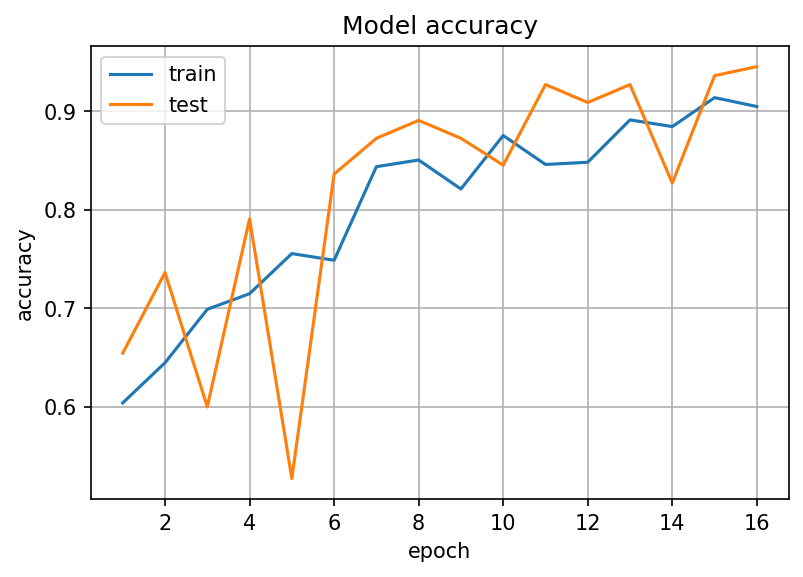

In [33]:
plt.figure(dpi=150)
plt.plot(df["accuracy"])
plt.plot(df["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.grid()
plt.legend(["train", "test"], loc="upper left")
ax = plt.gca()
ax.xaxis.get_major_locator().set_params(integer=True)
plt.show()

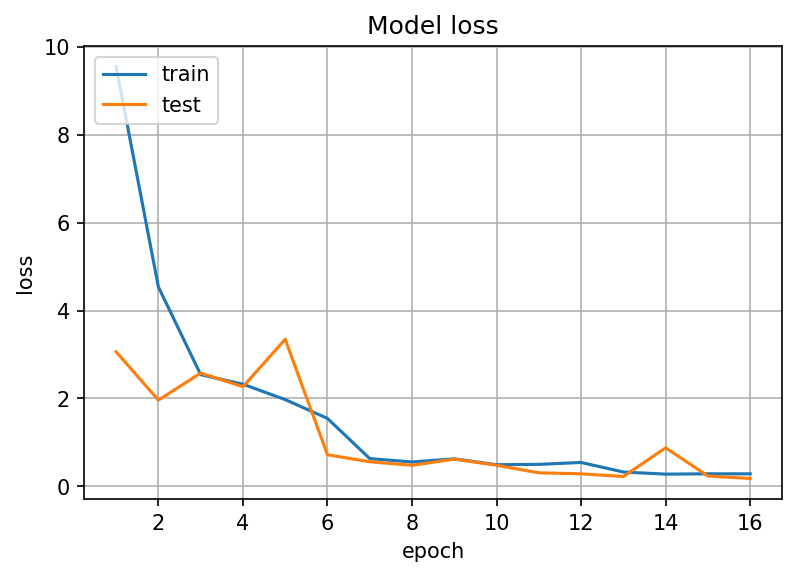

In [34]:
plt.figure(dpi=150)
plt.plot(df["loss"])
plt.plot(df["val_loss"])
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.grid()
plt.legend(["train", "test"], loc="upper left")
ax = plt.gca()
ax.xaxis.get_major_locator().set_params(integer=True)
plt.show()

In [35]:
predictions = model.predict(test_ds)

In [36]:
preds = np.round(predictions)

In [37]:
batches = list(test_ds.as_numpy_iterator())
true_labels = np.array([])
for batch in batches:
    true_labels = np.append(true_labels, batch[1])
    

In [38]:
true_labels.shape

(138,)

In [39]:
import numpy as np

In [40]:
tf.math.confusion_matrix(true_labels, preds)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[ 6, 34],
       [37, 61]])>

In [41]:
def plot_predictions(image_batch, label_batch, class_names):
    plt.figure(figsize=(10, 100))
    batch_size = image_batch.shape[0]
    for i in range(batch_size):
        ax = plt.subplot(batch_size, 3, i + 1)
        image = image_batch[i]
        plt.imshow(image.numpy().astype("uint8"))
        label = label_batch[i]
        predicted = round(model.predict(tf.expand_dims(image, axis=0))[0][0])
        plt.title("True: " + class_names[label] +"\nPrediction: " + class_names[predicted])
        plt.axis("off")

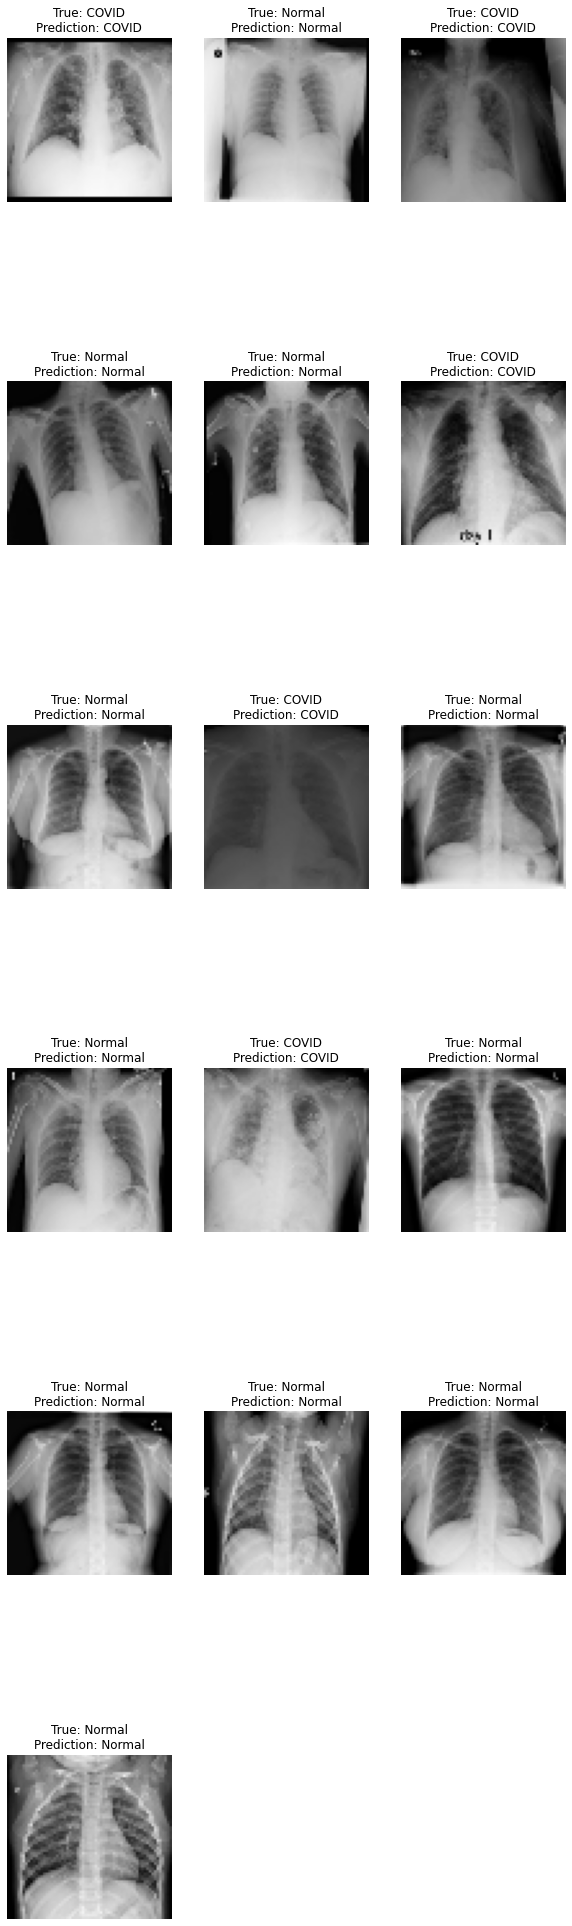

In [42]:
plot_predictions(test_image_batch, test_label_batch, class_names)